# Εργασία 1

## Α. Αναγνώριση μονών και ζυγών αριθμών στα δεκαδικά ψηφία της MNIST

### 1. Προετοιμασία των δεδομένων

Σκοπός της εργασίας είναι η αξιολόγηση μοντέλων τα οποία κατηγοριοποιούν εικόνες από χειρόγραφα ψηφία σε μονούς και ζυγούς αριθμούς.

Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

Παρακάτω βλέπουμε τις εκδόσεις των βιβλιοθηκών που χρησιμοποιήθηκαν στην εργασία.

In [1]:
import numpy as np
import matplotlib
import sklearn
import sys

print("Python version:", sys.version)
print('scikit-learn version:', sklearn.__version__)
print('numpy version:', np.__version__)
print('matplotlib version:', matplotlib.__version__)

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
scikit-learn version: 0.23.2
numpy version: 1.19.2
matplotlib version: 3.3.2


Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [2]:
import scipy.io
import urllib.request
import os

np.random.seed(0)

url = 'https://cs.nyu.edu/~roweis/data/mnist_all.mat'
filename = 'mnist_all.mat'

if not os.path.exists(filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Done.')

mat = scipy.io.loadmat(filename)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])

Οι εικόνες των ψηφίων έχουν μέγεθος 784 = 28x28.

Σκοπός της εργασίας είναι η αξιολόγηση μοντέλων τα οποία κατηγοριοποιούν εικόνες από χειρόγραφα ψηφία σε μονούς και ζυγούς αριθμούς. Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [3]:
digit = mat['train2'][0]
digit.shape

(784,)

Παρακάτω φαίνονται οι εικόνες πέντε ψηφίων.

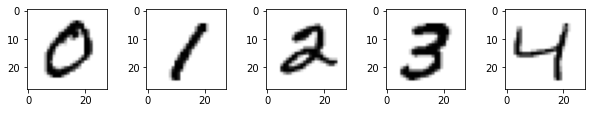

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 5
fig, axs = plt.subplots(1, n, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
for i in range(n):
    digit = mat['train' + str(i)][0]
    digit = digit.reshape((28, 28))
    axs[i].imshow(digit, cmap=plt.cm.binary)
plt.show()

Οι είκονες και οι ετικέτες φορτώνονται σε numpy arrays. Το μέγεθος του train set είναι 60000 και του test set 10000. Η κανονικοποίηση στο διάστημα [0, 1] γίνεται με διαίρεση με το 255 το οποίο είναι η μέγιστη τιμή της φωτεινότητας ενός pixel.

In [5]:
x_train, y_train, x_test, y_test = [], [], [], []

for key, data in mat.items():
    if 'train' in key:
        for x in data:
            x_train.append(x)
            num = int(key[-1])
            y_train.append(num)
    if 'test' in key:
        for x in data:
            x_test.append(x)
            num = int(key[-1])
            y_test.append(num)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test_original = x_test

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (60000, 784)
y_train.shape = (60000,)
x_test.shape = (10000, 784)
y_test.shape = (10000,)


In [6]:
x_train = x_train/255.
x_test = x_test/255.

print()
print('x_train is in [{}, {}]'.format(np.min(x_train), np.max(x_train)))
print('x_test is in [{}, {}]'.format(np.min(x_test), np.max(x_test)))


x_train is in [0.0, 1.0]
x_test is in [0.0, 1.0]


Το παρακάτω ιστόγραμμα μας δείχνει ότι οι κλάσεις των ψηφίων είναι ζυγισμένες. 

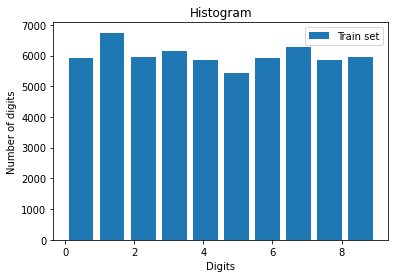

In [7]:
plt.hist(y_train, label='Train set', rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Λόγω του μεγάλου μεγέθους των δεδομένων, ως μέθοδος αξιολόγησης των μοντέλων, για την επιλογή των παραμέτρων τους, επιλέγεται η διαστρωματωμένη παρακράτηση (stratified holdout). Χρησιμοποιώντας αυτή τη μέθοδο χωρίζεται το train set ξανά σε train set και validation set διασφαλίζοντας ότι η κατανομή των κλάσεων παραμένει η ίδια και στα δύο set. Έτσι όλα τα ψηφία αντιπροσωπεύονται ισάξια.

In [8]:
from sklearn import model_selection

x_train_all = x_train
y_train_all = y_train

split = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, val_index in split.split(x_train_all, y_train_all):
    x_train, y_train = x_train_all[train_index], y_train_all[train_index]
    x_val, y_val = x_train_all[val_index], y_train_all[val_index]

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)

x_train.shape = (36000, 784)
y_train.shape = (36000,)
x_val.shape = (24000, 784)
y_val.shape = (24000,)


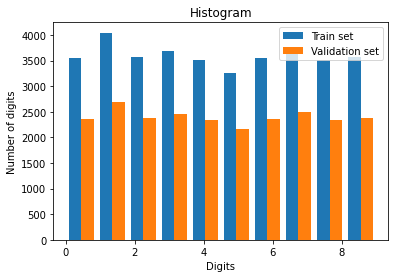

In [9]:
plt.hist((y_train, y_val), label=('Train set', 'Validation set'), rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Αλλάζουμε τις ετικέτες σε 0 και 1 έτσι ώστε να αντιπροσωπεύουν τους ζυγούς και τους μονούς αριθμούς αντίστοιχα.

In [10]:
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

### 2. Μείωση διαστάσεων

Γίνεται μείωση των διαστάσεων με την τεχνική PCA διατηρώντας το 90% της διασποράς. Η διάσταση των δεδομένων μειώνεται από 784 σε 87.

In [11]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.9, svd_solver='full')
x_train = pca.fit_transform(x_train)
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)

x_train_all = np.concatenate((x_train, x_val))
y_train_all = np.concatenate((y_train, y_val))

print('x_train_all.shape =', x_train_all.shape)
print('x_train.shape =', x_train.shape)
print('x_val.shape =', x_val.shape)
print('x_test.shape =', x_test.shape)

x_train_all.shape = (60000, 87)
x_train.shape = (36000, 87)
x_val.shape = (24000, 87)
x_test.shape = (10000, 87)


Οι κλάσεις δεν φαίνονται διαχωρίσιμες στο επίπεδο των δυο πρώτων ιδιοδιανυσμάτων.

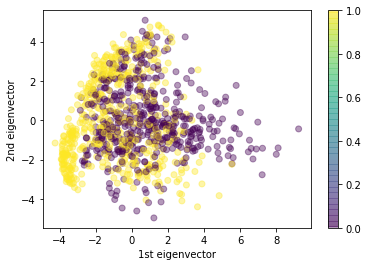

In [12]:
plt.scatter(x_train[:1000, 0], x_train[:1000, 1], c=y_train[:1000], cmap='viridis', alpha=0.4)
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')
plt.colorbar()
plt.show()

### 3.  Αξιολόγηση μοντέλων

#### 3.1 Περιγραφή της διαδικασίας

Η συνάρτηση grid_search αξιολογεί το κάθε μοντέλο στο validation set για διάφορες τιμές των παραμέτρων. Ως μετρική αξιολόγησης επιλέγεται το accuracy επείδη οι κλάσεις είναι ζυγισμένες και οι λάθος αποφάσεις για μονό ή ζυγό αριθμό θεωρούνται εξίσου σημαντικές. Έπειτα η plot_grid_search δημιουργεί διαγράμματα για το accuracy και τον χρόνο εκπαίδευσης. Τέλος η συνάρτηση evaluate_model εκπαιδεύει το βέλτιστο μοντέλο εκ νέου σε ολόκληρο το training set και το αξιολογεί στο test set και δίνει κάποια παραδείγματα σωστής και λάθους κατηγοριοποίησης.

In [13]:
from collections import defaultdict
from sklearn import metrics
from time import time


def grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=0):
    param_grid = model_selection.ParameterGrid(param_dict)
    all_params = list(param_grid)
    num = len(all_params)
    train_acc = np.zeros(num)
    val_acc = np.zeros(num)
    t = np.zeros(num)
    
    for i, params in enumerate(param_grid):
        model.set_params(**params)
        t1 = time()
        model.fit(x_train, y_train)
        t2 = time()
        t[i] = t2 - t1
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        train_acc[i] = metrics.accuracy_score(y_train, y_train_pred)
        val_acc[i] = metrics.accuracy_score(y_val, y_val_pred)
        if verbose >= 2:
            print('[{}/{}] {}: Train accuracy = {:.5f}, Validation accuracy = {:.5f} | t = {} sec = {:.1f} min'
             .format(i+1, num, params, train_acc[i], val_acc[i], int(t[i]), t[i]/60))
    
    best_i = np.argmax(val_acc)
    best_params = all_params[best_i]
    if verbose >= 1:
        print()
        print('Best params =', best_params)
        print('Maximum validation accuracy =', val_acc[best_i])
        print()
    
    results = {
        "params" : all_params,
        "train_score": train_acc,
        "val_score": val_acc,
        "time": t,
        "best_index": best_i,
        "best_params": best_params
    }
    
    return results


def plot_grid_search(results, param1, xscale='linear', param2=None):
    all_params = results["params"]
    train_acc = results["train_score"]
    val_acc = results["val_score"]
    t = results["time"]
    train_acc_dict = defaultdict(lambda: [])
    val_acc_dict = defaultdict(lambda: [])
    t_dict = defaultdict(lambda: [])
    values1_dict = defaultdict(lambda: [])
    
    for i, params in enumerate(all_params):
        if param2 in params:
            val2 = params[param2]
        else:
            val2 = None
        train_acc_dict[val2].append(train_acc[i])
        val_acc_dict[val2].append(val_acc[i])
        t_dict[val2].append(t[i])
        values1_dict[val2].append(params[param1])
    
    for val2, val_acc_vals in val_acc_dict.items():
        values1 = values1_dict[val2]
        if val2 is not None:
            label = param2 + ' = ' + str(val2) + ' (Validation)'
        else:
            label = 'Validation'
        plt.plot(values1, val_acc_vals, label=label)
    
    for val2, train_acc_vals in train_acc_dict.items():
        values1 = values1_dict[val2]
        if val2 is not None:
            label = param2 + ' = ' + str(val2) + ' (Train)'
        else:
            label = 'Train'
        plt.plot(values1, train_acc_vals, label=label, linestyle='dashed')
        
    plt.title('Score')
    plt.ylabel('Accuracy')
    plt.xlabel(param1)
    plt.xscale(xscale)
    plt.legend()
    plt.show()
    
    for val2, t_vals in t_dict.items():
        values1 = values1_dict[val2]
        if val2 is not None:
            label = param2 + ' = ' + str(val2)
        else:
            label = None
        plt.plot(values1, t_vals, label=label)
        
    plt.title('Training time')
    plt.ylabel('Time (sec)')
    plt.xlabel(param1)
    plt.xscale(xscale)
    if param2 is not None:
        plt.legend()
    plt.show()


def evaluate_model(model, best_params, x_train, y_train, x_test, y_test):   
    print('Training on the original training set with params =', best_params)
    model.set_params(**best_params)
    t1 = time()
    model.fit(x_train, y_train)
    t2 = time()
    print('Training time = {} sec = {:.1f} min'.format(int(t2 - t1), (t2 - t1)/60))
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    print('Train accuracy =', metrics.accuracy_score(y_train, y_train_pred)) 
    print('Test accuracy =', metrics.accuracy_score(y_test, y_test_pred))
    
    n = 5
    correct_indices = np.where(y_test == y_test_pred)[0]
    incorrect_indices = np.where(y_test != y_test_pred)[0]
    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)
    
    fig, axs = plt.subplots(1, n, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5)
    for j, i in enumerate(correct_indices[:n]):
        digit = x_test_original[i].reshape((28, 28))
        axs[j].imshow(digit, cmap=plt.cm.binary)
        axs[j].set_title("Correct")
    plt.show()
    
    fig, axs = plt.subplots(1, n, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5)
    for j, i in enumerate(incorrect_indices[:n]):
        digit = x_test_original[i].reshape((28, 28))
        axs[j].imshow(digit, cmap=plt.cm.binary)
        axs[j].set_title("Error")
    plt.show()

#### 3.2  Linear SVM

Ακολουθεί βελτιστοποίηση του SVM classifier με linear kernel ως προς την παράμετρο C. Το C είναι η παράμετρος αντιστάθμισης μεταξύ της προσπάθειας για μέγιστο περιθώριο μεταξύ των κλάσεων και για ελάχιστο αριθμό λαθών.

$ Loss = \mathbf{w}^T\mathbf{w} + C\sum_{k=1}^R\varepsilon_{k}\ $

Kernel: $ K(\mathbf{x}, \mathbf{x}') = \langle\mathbf{x},\mathbf{x}'\rangle $

In [ ]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

model = svm.SVC(kernel='linear')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

[1/7] {'C': 0.001}: Train accuracy = 0.87633, Validation accuracy = 0.87621 | t = 67 sec = 1.1 min
[2/7] {'C': 0.005}: Train accuracy = 0.88219, Validation accuracy = 0.88204 | t = 62 sec = 1.0 min
[3/7] {'C': 0.01}: Train accuracy = 0.88300, Validation accuracy = 0.88287 | t = 57 sec = 1.0 min
[4/7] {'C': 0.05}: Train accuracy = 0.88297, Validation accuracy = 0.88296 | t = 66 sec = 1.1 min
[5/7] {'C': 0.1}: Train accuracy = 0.88306, Validation accuracy = 0.88296 | t = 88 sec = 1.5 min


In [ ]:
plot_grid_search(results, "C", "log")

In [ ]:
evaluate_model(model, results["best_params"], x_train_all, y_train_all, x_test, y_test)

#### 3.3 Polynomial SVM

Ακολουθεί βελτιστοποίηση του SVM classifier με polynomial kernel ως προς τις παραμέτρους C και degree. Το degree είναι ο βαθμός του πολυωνύμου.

Kernel: $ K(\mathbf{x}, \mathbf{x}') = (\gamma\langle\mathbf{x},\mathbf{x}'\rangle+r)^d $

In [ ]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'degree': (2, 3, 4, 5)
}

model = svm.SVC(kernel='poly')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=1)

In [ ]:
plot_grid_search(results, "C", "log", "degree")

In [ ]:
evaluate_model(model, results["best_params"], x_train_all, y_train_all, x_test, y_test)

#### 3.4 RBF SVM

Ακολουθεί βελτιστοποίηση του SVM classifier με rbf kernel ως προς τις παραμέτρους C και gamma. Το gamma δείχνει πόσο μακριά φτάνει η επιρροή ενός παραδείγματος.

Kernel: $ K(\mathbf{x}, \mathbf{x}') = e^{-\gamma||\mathbf{x}-\mathbf{x}'||^2} $

In [ ]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.01, 0.1, 1.)
}

model = svm.SVC(kernel='rbf')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=1)

In [ ]:
plot_grid_search(results, "C", "log", "gamma")

In [ ]:
evaluate_model(model, results["best_params"], x_train_all, y_train_all, x_test, y_test)

#### 3.5 Sigmoid SVM

In [ ]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.001, 0.01, 0.1, 1.)
}

model = svm.SVC(kernel='sigmoid')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

In [ ]:
plot_grid_search(results, "C", "log", "gamma")

In [ ]:
evaluate_model(model, results["best_params"], x_train_all, y_train_all, x_test, y_test)

#### 3.6 Nearest Neighbor

In [ ]:
from sklearn import neighbors

param_dict = {
    'n_neighbors': range(1, 50, 2),
    'p': (1, 2, 3)
}

model = neighbors.KNeighborsClassifier()
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

In [ ]:
plot_grid_search(results, "n_neighbors", "p", "linear")

In [ ]:
evaluate_model(model, results["best_params"], x_train_all, y_train_all, x_test, y_test)

#### 3.7 Nearest Class Centroid

In [ ]:
param_dict = {
    'shrink_threshold': np.arange(0, 0.1, 1.1)
}

model = neighbors.NearestCentroid()
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

In [ ]:
plot_grid_search(results, "shrink_threshold")

In [ ]:
evaluate_model(model, results["best_params"], x_train_all, y_train_all, x_test, y_test)

#### 3.8 Σύνοψη αποτελεσμάτων